In [ ]:
#| default_exp metrics

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np

def PCK(pts: np.array, gt_pts: np.array, ths = np.arange(20)):
    '''Function to calculate  Probability of Correct Keypoint (PCK) given the error threshold'''
    assert pts.shape[0] == gt_pts.shape[0]
    assert pts.shape[1] == 2
    diff  = np.linalg.norm(pts - gt_pts, ord=2, axis=1)
    out = []
    for th in ths:
        correct = diff <= th
        out.append(correct.astype(np.float32).mean())
    return np.array(out)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#| export
import numpy as np
import cv2

def get_visible_part_mean_absolute_reprojection_error(img1_shape, img2_shape, H_gt, H):
    '''We reproject the image 1 mask to image2 and back to get the visible part mask.
    Then we average the reprojection absolute error over that area'''
    h,w = img1_shape[:2]
    mask1 = np.ones((h,w))
    mask1in2 = cv2.warpPerspective(mask1, H_gt, img2_shape[::-1])
    mask1inback = cv2.warpPerspective(mask1in2, np.linalg.inv(H_gt), img1_shape[:2][::-1]) > 0
    xi = np.arange(w)
    yi = np.arange(h)
    xg, yg = np.meshgrid(xi,yi)
    coords = np.concatenate([xg.reshape(*xg.shape,1), yg.reshape(*yg.shape,1)], axis=-1)
    shape_orig = coords.shape
    xy_rep_gt = cv2.perspectiveTransform(coords.reshape(-1, 1,2).astype(np.float32), H_gt.astype(np.float32)).squeeze(1)
    xy_rep_estimated = cv2.perspectiveTransform(coords.reshape(-1, 1,2).astype(np.float32),
                                                H.astype(np.float32)).squeeze(1)
    #error = np.abs(xy_rep_gt-xy_rep_estimated).sum(axis=1).reshape(xg.shape) * mask1inback
    error = np.sqrt(((xy_rep_gt-xy_rep_estimated)**2).sum(axis=1)).reshape(xg.shape) * mask1inback
    mean_error = error.sum() / mask1inback.sum()
    return mean_error


def get_mAA(mAE: np.array, ths=np.logspace(np.log2(1.0), np.log2(20), 10, base=2.0)):
    out = []
    for th in ths:
        correct = mAE <= th
        out.append(correct.astype(np.float32).mean())
    return out

Calculates `PCK` Probability of Correct Keypoint  given the error threshold

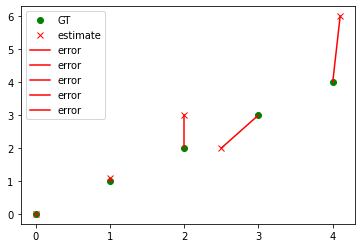

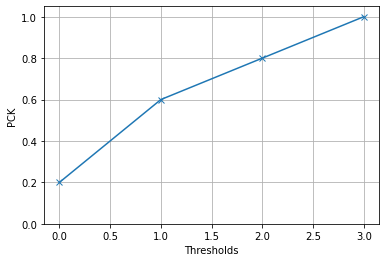

In [ ]:
import matplotlib.pyplot as plt
gt = np.stack([np.arange(5), np.arange(5)], axis=-1)
pts = np.array([[0,0],
               [1,1.1],
               [2,3],
               [2.5,2],
               [4.1,6]])
plt.plot(gt[:,0], gt[:,1], 'go', label='GT')
plt.plot(pts[:,0], pts[:,1], 'rx', label='estimate')
plt.plot(np.stack([pts[:,0], gt[:,0]], axis=0), 
         np.stack([pts[:,1], gt[:,1]], axis=0), 'r-', label='error')


plt.legend()
ths =  np.arange(4)
acc = PCK(pts, gt, np.arange(4))
plt.figure()
plt.plot(ths, acc, '-x')
plt.ylim([0,1.05])
plt.xlabel('Thresholds')
plt.ylabel('PCK')
plt.grid(True)

In [ ]:
#| export
import kornia.geometry as KG
import torch
def fraction_of_gt_corrs_consisent_with_F(Fm: np.array, gt_corrs: np.array, ths=np.arange(20)):
    assert Fm.shape == (3, 3)
    assert gt_corrs.shape[1] == 4
    pts_torch = torch.from_numpy(gt_corrs)[None]
    F_torch = torch.from_numpy(Fm)[None]
    errors = KG.symmetrical_epipolar_distance(pts_torch[:,:,:2],
                                              pts_torch[:,:,2:],
                                              F_torch, squared=False).detach().cpu().numpy().reshape(-1, 1)
    out = []
    for th in ths:
        correct = errors <= th
        out.append(correct.astype(np.float32).mean())
    return out

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calculates percentage of the ground truth correspondences, consistent with estimated fundamental matrix in a sense of the symmetrical epipolar distance. 
This is evaluation from the [WxBS paper](symmetrical_epipolar_distance), see the screenshot below:
![image.png](metrics_files/att_00000.png)

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


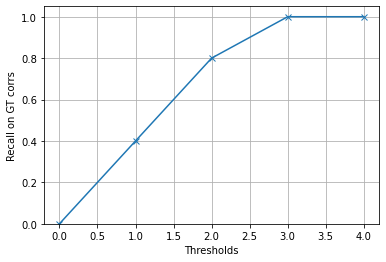

In [ ]:
pts1 = np.stack([np.arange(5),
               np.arange(5)], axis=-1)
pts2 = np.array([[0,0],
               [1,1.1],
               [2,3],
               [2.5,2],
               [4.1,6]])
corrs = np.concatenate([pts1, pts2], axis=1)
# Generate F for the purely horizontal shift between the cameras 
F = np.array([[0.0, 0.0, 0.0],
              [0.0, 0.0, -1.0],
              [0.0, 1.0, 0.0]])
ths = np.arange(5)
recall = fraction_of_gt_corrs_consisent_with_F(F, corrs, ths)
plt.figure()
plt.plot(ths, recall, '-x')
plt.ylim([0,1.05])
plt.xlabel('Thresholds')
plt.ylabel('Recall on GT corrs')
plt.grid(True)
